In [12]:
import pandas as pd

df = pd.read_csv(r"C:\gold_prediction_project\gold_data\gold_data.csv")
df

,Date_YYYY_MM,Gold_Price,US_M2_Money_Supply,US_CPI,Gold_Volume,Gold_Reserves_United States,Gold_Reserves_Germany,Gold_Reserves_Italy,Gold_Reserves_France,Gold_Reserves_Russia,...,Gold_Reserves_India,Gold_Reserves_Netherlands,Exchange_Rate_USD_CNY,Exchange_Rate_USD_EUR,Silver_Price,Dollar_Index,SP500,NASDAQ,Bond_Rate,VIX_Fear_Index
0,2010-01,1116.826300,8478.0,216.687,347218200,8214.300491,3392.470250,2476.156875,2461.108854,2322.747858,...,767.954029,618.584748,6.826916,1.426574,15.900000,79.500000,1073.869995,2147.350098,3.588,20.643158
1,2010-02,1098.189479,8527.6,216.741,368010500,8111.008546,3349.811128,2445.020072,2430.161274,2293.540119,...,758.297277,610.806262,6.828463,1.367995,16.070000,81.339996,1104.489990,2238.260010,3.619,22.540000
2,2010-03,1114.356525,8523.7,217.631,326092400,8238.859494,3402.613011,2483.560055,2468.467044,2329.692377,...,770.250047,620.434185,6.826183,1.357004,17.139999,82.239998,1169.430054,2397.959961,3.833,17.767391
3,2010-04,1151.452375,8555.1,218.009,274413100,8381.251267,3461.420192,2526.483292,2511.129429,2369.956327,...,783.562238,631.157116,6.825550,1.341682,18.260000,82.709999,1186.689941,2461.189941,3.659,17.424286
4,2010-05,1203.955005,8609.3,218.178,504968200,8095.410271,3343.369108,2440.318055,2425.487833,2289.129413,...,756.838995,609.631621,6.827450,1.256315,18.030001,87.459999,1089.410034,2257.040039,3.303,31.929500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2025-02,2897.115800,21584.2,319.082,178992600,7994.066180,3301.514441,2409.768422,2395.123855,2260.472467,...,747.364348,601.999820,7.273432,1.041300,28.309999,109.879997,5954.500000,18847.279297,4.202,16.968000
182,2025-03,2986.409528,21656.9,319.799,181005700,7959.297917,3287.155300,2399.287715,2384.706841,2250.641087,...,744.113867,599.381567,7.249252,1.081314,30.990000,107.559998,5611.850098,17299.289062,4.210,21.841429
183,2025-04,3211.152367,21804.7,320.795,354296400,8211.983788,3391.513462,2475.458517,2460.414741,2322.092766,...,767.737440,618.410287,7.296782,1.123177,29.600000,104.370003,5569.060059,17446.339844,4.175,31.966190
184,2025-05,3280.738095,21883.9,321.465,235215100,8097.149309,3344.087323,2440.842279,2426.008871,2289.621159,...,757.001578,609.762581,7.216557,1.127367,30.000000,101.980003,5911.689941,19113.769531,4.418,20.462273


c:\gold_prediction_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
LSTM 회귀 결과
R² Score  : 0.9091
RMSE      : 141.8155
MAE       : 111.8357


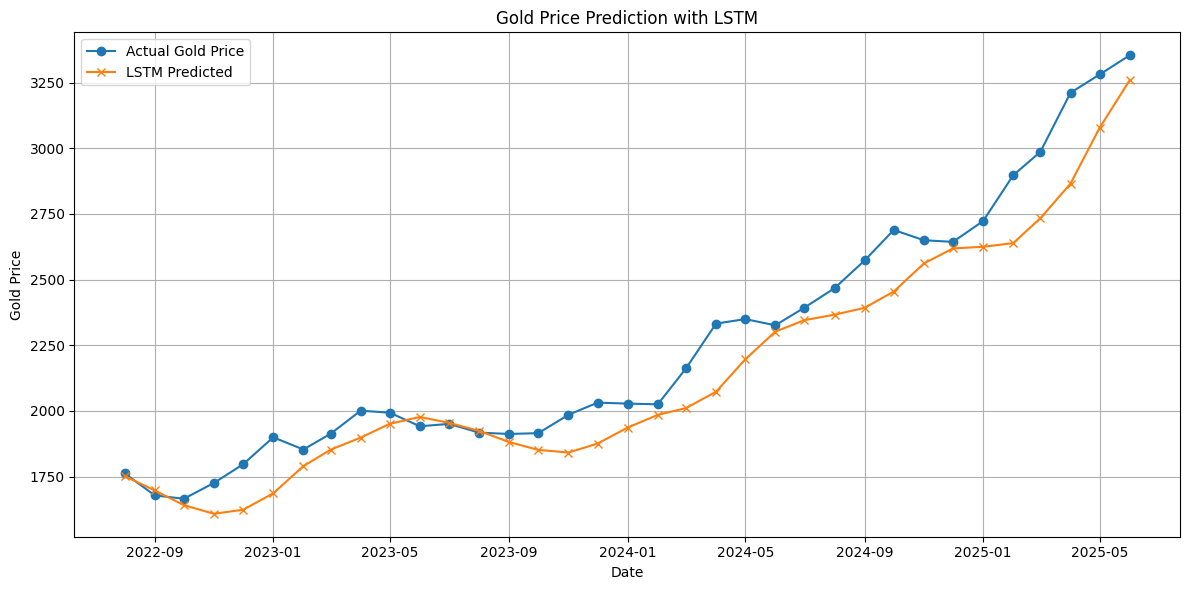

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ==============================
# 1. 데이터 준비
# ==============================
file_path = r"C:\gold_prediction_project\gold_data\gold_data.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

gold_prices = df['Gold_Price'].values.reshape(-1,1)

# 스케일링
scaler = MinMaxScaler()
gold_scaled = scaler.fit_transform(gold_prices)

# 시퀀스 생성 함수
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # 지난 12개월 데이터로 다음 달 예측
X, y = create_sequences(gold_scaled, seq_length)

# 학습/테스트 분리 (시계열이므로 shuffle=False)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ==============================
# 2. LSTM 모델 정의
# ==============================
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(seq_length,1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, verbose=0)

# ==============================
# 3. 예측 및 성능 평가
# ==============================
y_pred = model.predict(X_test)

# 스케일 복원
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 지표 계산
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("LSTM 회귀 결과")
print(f"R² Score  : {r2:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAE       : {mae:.4f}")

# ==============================
# 4. 실제 vs 예측 시각화 (X축을 Date로 변경)
# ==============================
# 시퀀스 때문에 y_test의 시작 인덱스는 seq_length만큼 밀려 있음
test_dates = df['Date'].iloc[seq_length + split : seq_length + len(X)]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_inv, label="Actual Gold Price", marker='o')
plt.plot(test_dates, y_pred_inv, label="LSTM Predicted", marker='x')
plt.title("Gold Price Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\gold_prediction_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
GRU 회귀 결과
R² Score  : 0.9504
RMSE      : 104.7133
MAE       : 78.9009


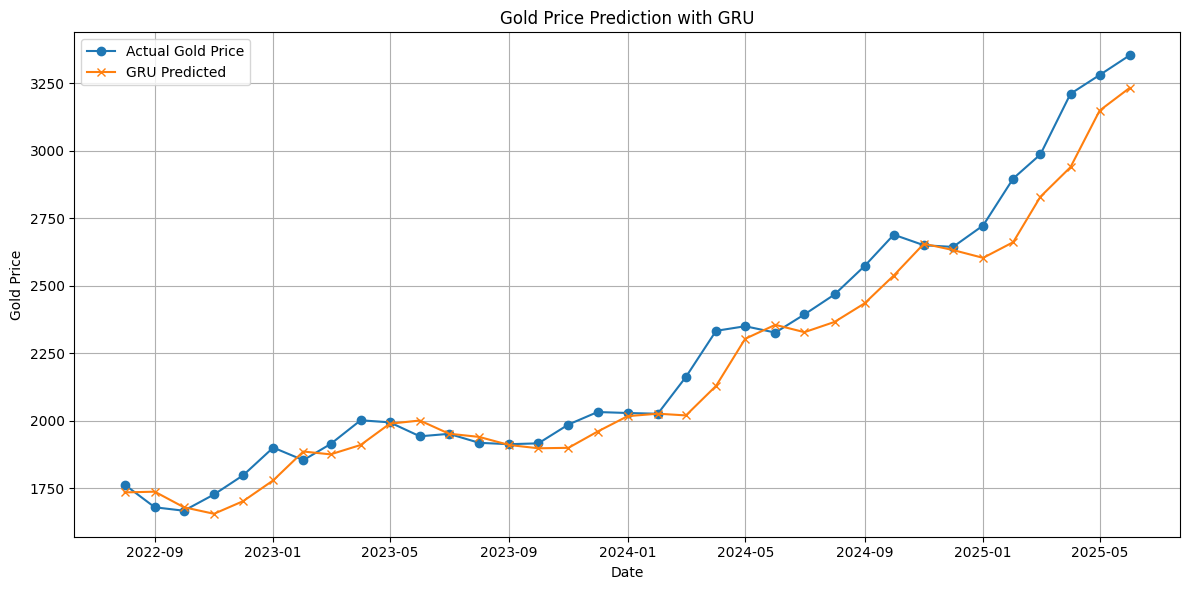

In [15]:
####### GRU #######

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# ==============================
# 1. 데이터 준비
# ==============================
file_path = r"C:\gold_prediction_project\gold_data\gold_data.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

gold_prices = df['Gold_Price'].values.reshape(-1,1)

# 스케일링
scaler = MinMaxScaler()
gold_scaled = scaler.fit_transform(gold_prices)

# 시퀀스 생성 함수
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # 지난 12개월 데이터로 다음 달 예측
X, y = create_sequences(gold_scaled, seq_length)

# 학습/테스트 분리 (80:20)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ==============================
# 2. GRU 모델 정의
# ==============================
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(seq_length,1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, verbose=0)

# ==============================
# 3. 예측 및 성능 평가
# ==============================
y_pred = model.predict(X_test)

# 스케일 복원
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 지표 계산
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("GRU 회귀 결과")
print(f"R² Score  : {r2:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAE       : {mae:.4f}")

# ==============================
# 4. 실제 vs 예측 시각화 (X축을 Date로 변경)
# ==============================
# y_test의 시작은 seq_length + split 번째 데이터부터
test_dates = df['Date'].iloc[seq_length + split : seq_length + len(X)]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_inv, label="Actual Gold Price", marker='o')
plt.plot(test_dates, y_pred_inv, label="GRU Predicted", marker='x')
plt.title("Gold Price Prediction with GRU")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


c:\gold_prediction_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
LSTM 회귀 결과
R² Score  : 0.9495
RMSE      : 105.7323
MAE       : 79.2910


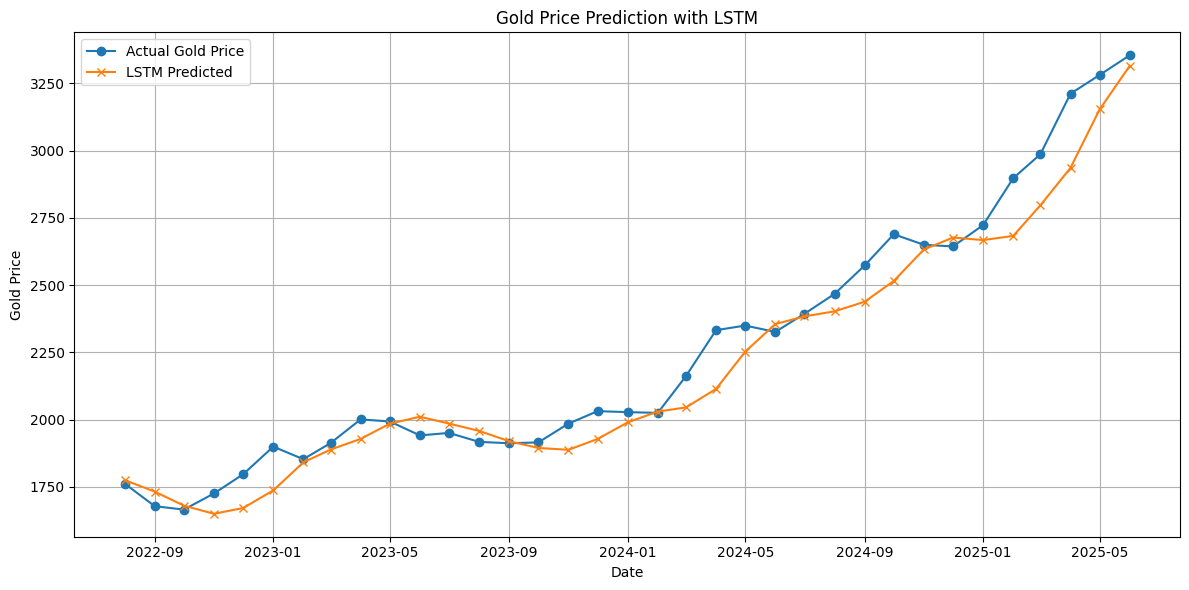

2025-07 : 3401.36
2025-08 : 3417.97
2025-09 : 3390.34
2025-10 : 3333.95
2025-11 : 3262.51
2025-12 : 3186.14
2026-01 : 3112.38


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ==============================
# 1. 데이터 준비
# ==============================
file_path = r"C:\gold_prediction_project\gold_data\gold_data.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

gold_prices = df['Gold_Price'].values.reshape(-1,1)

# 스케일링
scaler = MinMaxScaler()
gold_scaled = scaler.fit_transform(gold_prices)

# 시퀀스 생성 함수
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # 지난 12개월 데이터로 다음 달 예측
X, y = create_sequences(gold_scaled, seq_length)

# 학습/테스트 분리 (시계열이므로 shuffle=False)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ==============================
# 2. LSTM 모델 정의
# ==============================
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(seq_length,1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, verbose=0)

# ==============================
# 3. 예측 및 성능 평가
# ==============================
y_pred = model.predict(X_test)

# 스케일 복원
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 지표 계산
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("LSTM 회귀 결과")
print(f"R² Score  : {r2:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAE       : {mae:.4f}")

# ==============================
# 4. 실제 vs 예측 시각화 (X축을 Date로 변경)
# ==============================
# 시퀀스 때문에 y_test의 시작 인덱스는 seq_length만큼 밀려 있음
test_dates = df['Date'].iloc[seq_length + split : seq_length + len(X)]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_inv, label="Actual Gold Price", marker='o')
plt.plot(test_dates, y_pred_inv, label="LSTM Predicted", marker='x')
plt.title("Gold Price Prediction with LSTM")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 5. 미래(2025년 7월) 예측
# ==============================

future_months = 7  # 7개월 뒤까지 예측 (마지막 데이터 기준)
last_sequence = gold_scaled[-seq_length:]  # 마지막 12개월 시퀀스

future_predictions = []

current_seq = last_sequence.reshape(1, seq_length, 1)

for _ in range(future_months):
    next_pred = model.predict(current_seq, verbose=0)  # (1,1) shape
    future_predictions.append(next_pred[0,0])

    # (1,1,1) 형태로 변환
    next_pred_reshaped = next_pred.reshape(1,1,1)

    # 시퀀스 업데이트 (맨 앞 제거 + 새 값 추가)
    current_seq = np.append(current_seq[:,1:,:], next_pred_reshaped, axis=1)


# 스케일 복원
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

# 미래 날짜 생성
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(), periods=future_months, freq='MS')

# 출력
for d, p in zip(future_dates, future_predictions_inv):
    print(f"{d.strftime('%Y-%m')} : {p[0]:.2f}")


c:\gold_prediction_project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
GRU 회귀 결과
R² Score  : 0.9370
RMSE      : 118.0562
MAE       : 91.5327


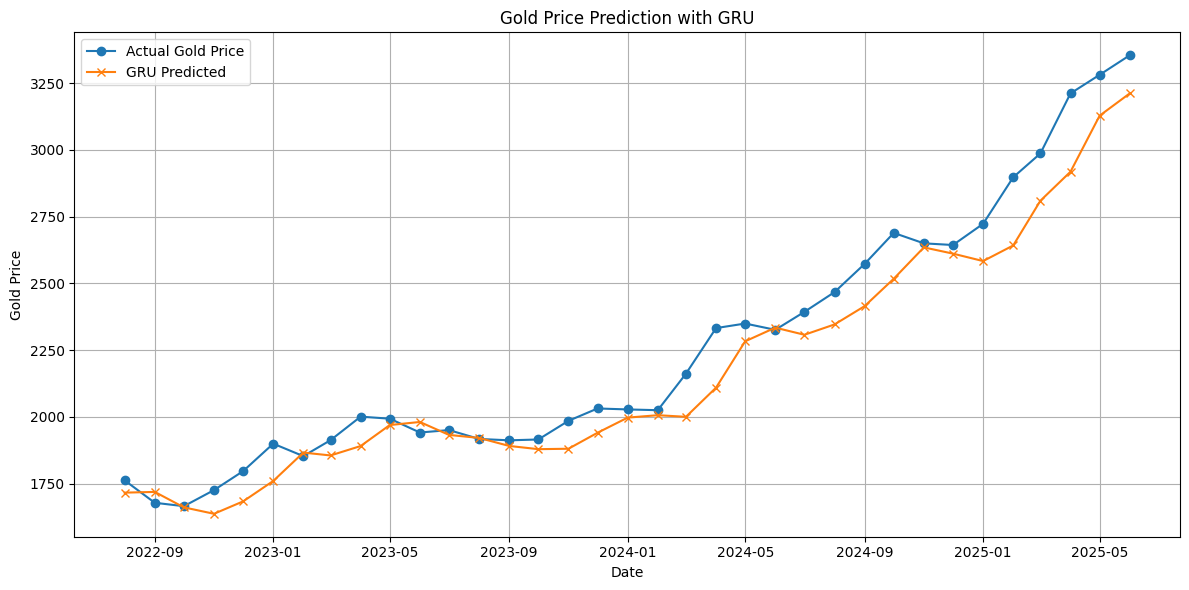

2025-07 : 3263.89
2025-08 : 3163.37
2025-09 : 3034.99
2025-10 : 2893.30
2025-11 : 2747.89
2025-12 : 2605.33
2026-01 : 2470.05


In [17]:
####### GRU #######

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# ==============================
# 1. 데이터 준비
# ==============================
file_path = r"C:\gold_prediction_project\gold_data\gold_data.csv"
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date_YYYY_MM'])
df = df.sort_values('Date').reset_index(drop=True)

gold_prices = df['Gold_Price'].values.reshape(-1,1)

# 스케일링
scaler = MinMaxScaler()
gold_scaled = scaler.fit_transform(gold_prices)

# 시퀀스 생성 함수
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # 지난 12개월 데이터로 다음 달 예측
X, y = create_sequences(gold_scaled, seq_length)

# 학습/테스트 분리 (80:20)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ==============================
# 2. GRU 모델 정의
# ==============================
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(seq_length,1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=8, validation_split=0.1, verbose=0)

# ==============================
# 3. 예측 및 성능 평가
# ==============================
y_pred = model.predict(X_test)

# 스케일 복원
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# 지표 계산
r2 = r2_score(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("GRU 회귀 결과")
print(f"R² Score  : {r2:.4f}")
print(f"RMSE      : {rmse:.4f}")
print(f"MAE       : {mae:.4f}")

# ==============================
# 4. 실제 vs 예측 시각화 (X축을 Date로 변경)
# ==============================
# y_test의 시작은 seq_length + split 번째 데이터부터
test_dates = df['Date'].iloc[seq_length + split : seq_length + len(X)]

plt.figure(figsize=(12,6))
plt.plot(test_dates, y_test_inv, label="Actual Gold Price", marker='o')
plt.plot(test_dates, y_pred_inv, label="GRU Predicted", marker='x')
plt.title("Gold Price Prediction with GRU")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==============================
# 5. 미래(2025년 7월) 예측
# ==============================

future_months = 7  # 7개월 뒤까지 예측 (마지막 데이터 기준)
last_sequence = gold_scaled[-seq_length:]  # 마지막 12개월 시퀀스

future_predictions = []

current_seq = last_sequence.reshape(1, seq_length, 1)

for _ in range(future_months):
    next_pred = model.predict(current_seq, verbose=0)  # (1,1) shape
    future_predictions.append(next_pred[0,0])

    # (1,1,1) 형태로 변환
    next_pred_reshaped = next_pred.reshape(1,1,1)

    # 시퀀스 업데이트 (맨 앞 제거 + 새 값 추가)
    current_seq = np.append(current_seq[:,1:,:], next_pred_reshaped, axis=1)


# 스케일 복원
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))

# 미래 날짜 생성
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(last_date + pd.offsets.MonthBegin(), periods=future_months, freq='MS')

# 출력
for d, p in zip(future_dates, future_predictions_inv):
    print(f"{d.strftime('%Y-%m')} : {p[0]:.2f}")
